Nama: Faishal Kamil<br>
NIM: 2502001063<br>
Course: Deep Learning


## **Problem Statement**
----
Dalam dataset yang disediakan terdapat informasi penting mengenai keterangan setiap kolomnya. Yang akan digunakan kolom Date dan Close saja. Buatlah arsitektur Long Short Term Memory (LSTM). Berikut adalah ketentuan yang perlu diperhatikan dalam pembuatan arsitektur LSTM. <br>

a. Lakukan eksplorasi data terlebih dahulu untuk memahami permasalahan yang dihadapi terlebih dahulu. Dataset yang diberikan adalah data time series, lakukan praproses data untuk menyelesaikan problem dari data tersebut. Pisahkan data time series tersebut menjadi dua bagian input dan output dengan window size = 5 [dari hari senin s.d
jumat] dan horizon = 1 hari senin saja. Selanjutnya pisahkan dataset menjadi train, test dan validation set dengan ketentuan (80% train, 10% val, 10% test) <br>

b. Buatlah arsitektur baseline dengan LSTM (units=50) dan layer akhir berupa node Perceptron dengan units=1. Activation function untuk LSTM menggunakan ReLU

c. Setelah mengetahui hasil dari nomor (1c), modifikasi arsitektur pada nomor 1c untuk mendapatkan unjuk kerja yang optimal (kalian dapat
menambahkan atau mengurangi arsitektur tersebut, atau mengganti hyperparameter, atau menggunakan tuning pada hyperparameter). Jelaskan alasan kalian untuk menggunakan pendekatan yang kalian pilih.

d. Lakukan evaluasi unjuk kerja kedua arsitektur di atas pada test set dengan mencari nilai RMSE, MAE dan MAPE. Dan berikan penjelasan mengenai hasilnya dengan rinci.

e. Buatlah video presentasi yang menjelaskan arsitektur yang dibangun untuk mengklasifikasikan sebuah klaim ini.

Pada problem ini saya menggunakan indeks saham INTC

## 1a Dataset Exploration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ef3d9db0-2b91-e6f5-7b30-f07d045299b9)


In [ ]:
# Load dataset
df = pd.read_csv("/content/drive/My Drive/UASDeepLearning/INTC.csv")

In [ ]:
df = pd.DataFrame(df)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.325521,0.330729,0.325521,0.325521,0.204750,10924800
1,1980-03-18,0.325521,0.328125,0.322917,0.322917,0.203112,17068800
2,1980-03-19,0.330729,0.335938,0.330729,0.330729,0.208026,18508800
3,1980-03-20,0.330729,0.334635,0.329427,0.329427,0.207207,11174400
4,1980-03-21,0.322917,0.322917,0.317708,0.317708,0.199836,12172800
...,...,...,...,...,...,...,...
10093,2020-03-26,51.740002,55.950001,51.660000,55.540001,55.540001,41459800
10094,2020-03-27,53.419998,54.639999,52.070000,52.369999,52.369999,31633500
10095,2020-03-30,52.990002,56.099998,52.830002,55.490002,55.490002,31628600
10096,2020-03-31,55.060001,55.799999,53.220001,54.119999,54.119999,48074700


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10098 entries, 0 to 10097
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10098 non-null  object 
 1   Open       10098 non-null  float64
 2   High       10098 non-null  float64
 3   Low        10098 non-null  float64
 4   Close      10098 non-null  float64
 5   Adj Close  10098 non-null  float64
 6   Volume     10098 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 552.4+ KB


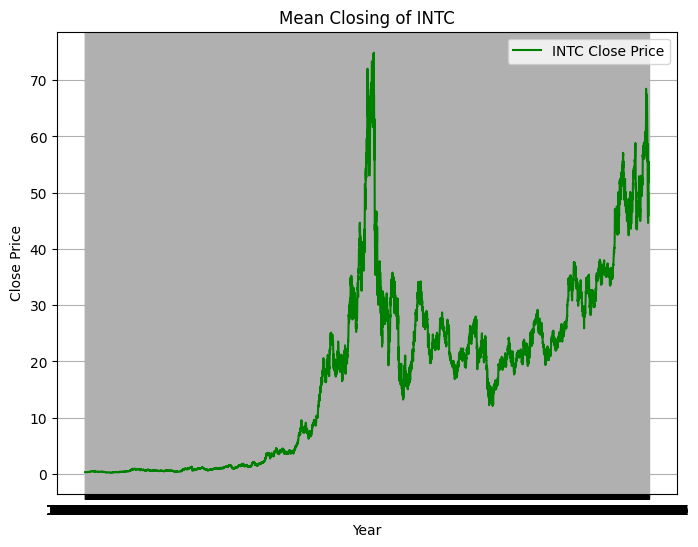

In [ ]:
# Grouping data of INTC to see trend over years with mean
intc_years = df.groupby('Date')['Close'].mean()

plt.figure(figsize=(8, 6))
plt.plot(intc_years.index, intc_years, label='INTC Close Price', color="green")
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.title('Mean Closing of INTC')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df_price = df['Close']
df_price.head(10)

Date
1980-03-17    0.325521
1980-03-18    0.322917
1980-03-19    0.330729
1980-03-20    0.329427
1980-03-21    0.317708
1980-03-24    0.311198
1980-03-25    0.312500
1980-03-26    0.309896
1980-03-27    0.299479
1980-03-28    0.311198
Name: Close, dtype: float64

Text(0, 0.5, 'INTC Price')

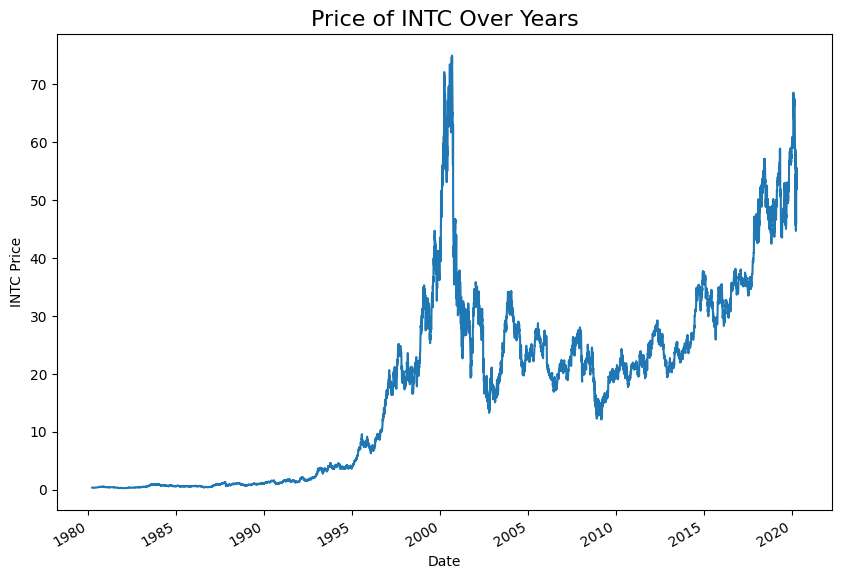

In [ ]:
# Plotting the time series
df_price.plot(figsize=(10,7))
plt.title('Price of INTC Over Years',fontsize=16)
plt.xlabel('Date')
plt.ylabel('INTC Price')

Splitting Data

In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.325521,0.330729,0.325521,0.325521,0.204750,10924800
1,1980-03-18,0.325521,0.328125,0.322917,0.322917,0.203112,17068800
2,1980-03-19,0.330729,0.335938,0.330729,0.330729,0.208026,18508800
3,1980-03-20,0.330729,0.334635,0.329427,0.329427,0.207207,11174400
4,1980-03-21,0.322917,0.322917,0.317708,0.317708,0.199836,12172800
...,...,...,...,...,...,...,...
10093,2020-03-26,51.740002,55.950001,51.660000,55.540001,55.540001,41459800
10094,2020-03-27,53.419998,54.639999,52.070000,52.369999,52.369999,31633500
10095,2020-03-30,52.990002,56.099998,52.830002,55.490002,55.490002,31628600
10096,2020-03-31,55.060001,55.799999,53.220001,54.119999,54.119999,48074700


In [ ]:
# Data yang hanya akan digunakan
df = df[['Date', 'Close']]
df

,Date,Close
0,1980-03-17,0.325521
1,1980-03-18,0.322917
2,1980-03-19,0.330729
3,1980-03-20,0.329427
4,1980-03-21,0.317708
...,...,...
10093,2020-03-26,55.540001
10094,2020-03-27,52.369999
10095,2020-03-30,55.490002
10096,2020-03-31,54.119999


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

<ipython-input-13-b9c6864122be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


In [ ]:
df.set_index('Date', inplace=True) #set Date column as index

In [ ]:
df

,Close
Date,
1980-03-17,0.325521
1980-03-18,0.322917
1980-03-19,0.330729
1980-03-20,0.329427
1980-03-21,0.317708
...,...
2020-03-26,55.540001
2020-03-27,52.369999
2020-03-30,55.490002


In [ ]:
seed = 42
np.random.seed(seed)

# Normalisasi Dataset
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

window_size = 5
horizon = 1

<ipython-input-16-ce7f8a17444b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df[['Close']])


In [ ]:
def split(sequence, window_size, horizon):
    X, y = [], []
    for i in range(len(sequence)):
        end_idx = i + window_size
        out_end_idx = end_idx + horizon
        if out_end_idx > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_idx], sequence[end_idx:out_end_idx]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
X, y = split(df['Close'].values, window_size, horizon)

# Splitting Dataset Into 80% Traininng, 10% Validation, and 10% Test as mentioned in question
train = int(0.8 * len(X))
val = int(0.1 * len(X))
test = len(X) - train - val

X_train, y_train = X[:train], y[:train]
X_val, y_val = X[train:train+val], y[train:train+val]
X_test, y_test = X[train+val:], y[train+val:]

## 1b Create Baseline
----
Membuat baseline yang mana akan di optimalisasi di step berikutnya

In [ ]:
# Inisialisasi model
model_baseline = Sequential()

# Tambahkan layer LSTM dengan ReLU dan dropout
model_baseline.add(LSTM(units=50, activation='relu', input_shape=(window_size, 1)))

# Tambahkan layer output dengan satu node Perceptron
model_baseline.add(Dense(units=1))

# Compile model
model_baseline.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model_baseline.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/30
253/253 [==============================] - 10s 13ms/step - loss: 0.0037 - val_loss: 6.5514e-05
Epoch 2/30
253/253 [==============================] - 3s 11ms/step - loss: 1.1918e-04 - val_loss: 6.2367e-05
Epoch 3/30
253/253 [==============================] - 5s 20ms/step - loss: 1.1761e-04 - val_loss: 1.1104e-04
Epoch 4/30
253/253 [==============================] - 3s 12ms/step - loss: 1.2134e-04 - val_loss: 7.2685e-05
Epoch 5/30
253/253 [==============================] - 5s 18ms/step - loss: 1.1804e-04 - val_loss: 5.8807e-05
Epoch 6/30
253/253 [==============================] - 5s 19ms/step - loss: 1.1583e-04 - val_loss: 9.1160e-05
Epoch 7/30
253/253 [==============================] - 4s 15ms/step - loss: 1.1660e-04 - val_loss: 6.0816e-05
Epoch 8/30
253/253 [==============================] - 3s 12ms/step - loss: 1.0615e-04 - val_loss: 5.3571e-05
Epoch 9/30
253/253 [==============================] - 4s 16ms/step - loss: 1.0753e-04 - val_loss: 5.2741e-05
Epoch 10/30
253/253 [=

In [ ]:
# Predict model dengan test data
y_predictBaseline = model_baseline.predict(X_test)

# Transform Data karena sebelum saya di scaling
y_test = scaler.inverse_transform(y_test)
y_pred_baseline = scaler.inverse_transform(y_predictBaseline)

rmse_baseline = np.sqrt(mean_squared_error(y_test, y_predictBaseline))
r2_baseline = r2_score(y_test, y_predictBaseline)
mae_baseline = mean_absolute_error(y_test, y_predictBaseline)
mape_baseline = np.mean(np.abs((y_test - y_predictBaseline) / y_test)) * 100

32/32 [==============================] - 0s 2ms/step


In [ ]:
print("\t Baseline Model Evaluation")
print("============================================")
print("RMSE\t\t\t:", rmse_baseline)
print("R2 Score\t\t:", r2_baseline)
print("MAE\t\t\t:", mae_baseline)
print("MAPE\t\t\t:", mape_baseline)

	 Baseline Model Evaluation
RMSE			: 44.854250763137784
R2 Score		: -25.32777909802679
MAE			: 44.017054392884276
MAPE			: 98.66726979993025


## Modify Baseline Architecture (Optimized Architecture)
----

In [ ]:
modelMod = Sequential()
modelMod.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(window_size, 1)))
modelMod.add(LSTM(128, activation='relu'))
modelMod.add(Dense(64, activation='relu'))
modelMod.add(Dense(1))

modelMod.compile(optimizer='adam', loss='mse')

modelMod.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
253/253 [==============================] - 12s 25ms/step - loss: 0.0027 - val_loss: 1.0690e-04
Epoch 2/50
253/253 [==============================] - 8s 31ms/step - loss: 2.2263e-04 - val_loss: 3.0800e-04
Epoch 3/50
253/253 [==============================] - 6s 24ms/step - loss: 2.2412e-04 - val_loss: 1.6051e-04
Epoch 4/50
253/253 [==============================] - 8s 32ms/step - loss: 2.0023e-04 - val_loss: 7.9308e-05
Epoch 5/50
253/253 [==============================] - 6s 24ms/step - loss: 1.9963e-04 - val_loss: 3.3329e-04
Epoch 6/50
253/253 [==============================] - 8s 31ms/step - loss: 1.9218e-04 - val_loss: 3.4237e-04
Epoch 7/50
253/253 [==============================] - 8s 31ms/step - loss: 1.9046e-04 - val_loss: 6.7857e-04
Epoch 8/50
253/253 [==============================] - 8s 31ms/step - loss: 1.7475e-04 - val_loss: 9.0269e-05
Epoch 9/50
253/253 [==============================] - 6s 24ms/step - loss: 1.5143e-04 - val_loss: 6.1899e-05
Epoch 10/50
253/253 [=

In [ ]:
# Predict model dengan test data
y_predictMod1 = model_baseline.predict(X_test)

# Transform Data karena sebelumnya di scaling
y_predictMod1 = scaler.inverse_transform(y_predictMod1)

rmse_Mod1 = np.sqrt(mean_squared_error(y_test, y_predictMod1))
r2_Mod1 = r2_score(y_test, y_predictMod1)
mae_Mod1 = mean_absolute_error(y_test, y_predictMod1)
mape_Mod1 = np.mean(np.abs((y_test - y_predictMod1) / y_test)) * 100

32/32 [==============================] - 0s 2ms/step


In [ ]:
print("\t Modified Model 1 Evaluation")
print("============================================")
print("RMSE\t\t\t:", rmse_Mod1)
print("R2 Score\t\t:", r2_Mod1)
print("MAE\t\t\t:", mae_Mod1)
print("MAPE\t\t\t:", mape_Mod1)

	 Modified Model 1 Evaluation
RMSE			: 0.9565572979921427
R2 Score		: 0.9880262829561169
MAE			: 0.6003277485913563
MAPE			: 1.293403394079131


**Model 2** : Menggunakan GridSearchCV untuk menentukan hyperparameterapa saja yang harus dituning sehingga meningkatkan akurasi pada metrik yang ditentukan

References:

*   https://faroit.com/keras-docs/1.0.1/getting-started/sequential-model-guide/
*   https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html



In [ ]:

def model(units=64, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units, activation='relu', return_sequences=True, input_shape=(window_size, 1)))
    model.add(LSTM(units//4, activation='relu'))
    model.add(Dense(units//6, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

modelMod2 = KerasRegressor(build_fn=model, epochs=50, batch_size=32, verbose=0)

# Pilih hyperparameter yang akan digunakan pada gridsearchcv
param_grid = {
    'units': [64, 128, 256],
    'optimizer': ['adam', 'rmsprop']
}

grid_search = GridSearchCV(estimator=modelMod2, param_grid=param_grid, cv=3)
grid_result = grid_search.fit(X_train, y_train)

print("Best score: %f, using params: %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-43-d23a4543186f>:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  modelMod2 = KerasRegressor(build_fn=model, epochs=50, batch_size=32, verbose=0)


Best score: -0.000134, using params: {'optimizer': 'adam', 'units': 256}


In [ ]:
best_units = grid_result.best_params_['units']
best_optimizer = grid_result.best_params_['optimizer']

modelMod2 = model(units=best_units, optimizer=best_optimizer)
modelMod2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
253/253 [==============================] - 18s 52ms/step - loss: 0.0030 - val_loss: 9.0066e-05
Epoch 2/50
253/253 [==============================] - 6s 26ms/step - loss: 2.0133e-04 - val_loss: 1.1459e-04
Epoch 3/50
253/253 [==============================] - 8s 30ms/step - loss: 1.9689e-04 - val_loss: 2.9663e-04
Epoch 4/50
253/253 [==============================] - 7s 26ms/step - loss: 2.1687e-04 - val_loss: 1.7523e-04
Epoch 5/50
253/253 [==============================] - 8s 30ms/step - loss: 1.8533e-04 - val_loss: 2.6395e-04
Epoch 6/50
253/253 [==============================] - 7s 27ms/step - loss: 1.8532e-04 - val_loss: 1.4302e-04
Epoch 7/50
253/253 [==============================] - 8s 32ms/step - loss: 1.7989e-04 - val_loss: 6.9020e-05
Epoch 8/50
253/253 [==============================] - 9s 36ms/step - loss: 1.5900e-04 - val_loss: 8.9763e-05
Epoch 9/50
253/253 [==============================] - 6s 24ms/step - loss: 1.4274e-04 - val_loss: 8.0112e-04
Epoch 10/50
253/253 [=

In [ ]:
y_predictMod2 = modelMod2.predict(X_test)
y_predictMod2 = scaler.inverse_transform(y_predictMod2)

rmseMod2 = np.sqrt(mean_squared_error(y_test, y_predictMod2))
r2Mod2 = r2_score(y_test, y_predictMod2)
maeMod2 = mean_absolute_error(y_test, y_predictMod2)
mapeMod2 = np.mean(np.abs((y_test - y_predictMod2) / y_test)) * 100

print("   Modified Model 2 GridSCV Evaluation")
print("============================================")
print("RMSE\t\t:", rmseMod2)
print("R2 Score\t:", r2Mod2)
print("MAE\t\t:", maeMod2)
print("MAPE\t\t:", mapeMod2)

32/32 [==============================] - 0s 3ms/step
   Modified Model 2 GridSCV Evaluation
RMSE		: 0.9865935283627274
R2 Score	: 0.9872625193673952
MAE		: 0.5957352269994144
MAPE		: 1.2743013611176233


## 1c. Evaluation

In [ ]:
print("============================================")
print("\t\t EVALUATION")
print("============================================")
print("\n")
print("\t Baseline Model Evaluation")
print("============================================")
print("RMSE\t\t\t:", rmse_baseline)
print("R2 Score\t\t:", r2_baseline)
print("MAE\t\t\t:", mae_baseline)
print("MAPE\t\t\t:", mape_baseline)


print("\t Modified Model 1 Evaluation")
print("============================================")
print("RMSE\t\t\t:", rmse_Mod1)
print("R2 Score\t\t:", r2_Mod1)
print("MAE\t\t\t:", mae_Mod1)
print("MAPE\t\t\t:", mape_Mod1)


print("   Modified Model 2 GridSCV Evaluation")
print("============================================")
print("RMSE\t\t\t:", rmseMod2)
print("R2 Score\t\t:", r2Mod2)
print("MAE\t\t\t:", maeMod2)
print("MAPE\t\t\t:", mapeMod2)

		 EVALUATION


	 Baseline Model Evaluation
RMSE			: 44.854250763137784
R2 Score		: -25.32777909802679
MAE			: 44.017054392884276
MAPE			: 98.66726979993025
	 Modified Model 1 Evaluation
RMSE			: 0.9565572979921427
R2 Score		: 0.9880262829561169
MAE			: 0.6003277485913563
MAPE			: 1.293403394079131
   Modified Model 2 GridSCV Evaluation
RMSE			: 0.9865935283627274
R2 Score		: 0.9872625193673952
MAE			: 0.5957352269994144
MAPE			: 1.2743013611176233


Terdapat perbedaan yang signifikan antara performa model dasar (baseline model) dan model yang dimodifikasi. Performa model yang dimodifikasi lebih baik dalam beberapa aspek evaluasi seperti RMSE, R2 Score, MAE, dan MAPE. Nilai-nilai performa yang lebih kecil pada model yang dimodifikasi menunjukkan peningkatan yang signifikan dalam akurasi prediksi dan kemampuan penjelasan. <br>

Dalam hal RMSE, model yang dimodifikasi menghasilkan nilai yang lebih kecil dibandingkan dengan baseline model. Hal ini menunjukkan bahwa model yang dimodifikasi memiliki kesalahan prediksi yang lebih rendah dan mampu memperkirakan harga saham INTC dengan lebih akurat. Model tersebut mampu memberikan prediksi yang lebih dekat dengan nilai aktual, sehingga meminimalkan kesalahan dalam estimasi harga saham INTC.<br>

Selanjutnya, R2 Score yang mendekati 1 pada model yang dimodifikasi menunjukkan bahwa model tersebut dapat menjelaskan sebagian besar variasi dalam data harga saham INTC. Model yang dimodifikasi mampu menangkap pola dan tren dalam data dengan lebih baik, sehingga memiliki kemampuan yang lebih baik dalam memberikan penjelasan atas variasi yang ada.<br>

Selain itu, nilai MAE yang lebih kecil pada model yang dimodifikasi menunjukkan bahwa model tersebut memiliki kesalahan prediksi yang lebih rendah secara keseluruhan. Model yang dimodifikasi memberikan estimasi harga saham INTC dengan tingkat kesalahan yang lebih rendah dibandingkan dengan baseline model, tanpa mempertimbangkan arah kesalahan.<br>

Terakhir, nilai MAPE yang lebih kecil pada model yang dimodifikasi menunjukkan bahwa model tersebut memiliki tingkat kesalahan yang lebih rendah dalam memprediksi persentase perubahan harga saham INTC. Model tersebut memberikan prediksi yang lebih akurat dalam memperkirakan persentase perubahan harga saham, sehingga bermanfaat bagi para pemangku kepentingan yang memerlukan informasi tentang pergerakan harga saham.<br>

========================================== <br>
Dari hasil evaluasi performa model, dapat ditarik kesimpulan dan analisis yang mendalam sebagai berikut:

1. **Baseline Model**: Baseline model menunjukkan kinerja yang buruk dalam memprediksi harga saham INTC. Dalam hal RMSE, nilai yang tinggi (44.85) menunjukkan bahwa model memiliki kesalahan prediksi yang besar. R2 Score yang negatif (-25.33) menunjukkan bahwa model tidak mampu menjelaskan variasi dalam data dengan baik. MAE yang tinggi (44.02) dan MAPE yang mencapai 98.67% juga menunjukkan tingkat kesalahan yang signifikan dalam memprediksi harga saham INTC.

2. **Modified Model 1**: Model yang dimodifikasi 1 menunjukkan peningkatan yang signifikan dalam performa dibandingkan dengan baseline model. RMSE yang rendah (0.96) menunjukkan kesalahan prediksi yang lebih kecil, dan R2 Score yang mendekati 1 (0.99) menunjukkan kemampuan yang baik dalam menjelaskan variasi dalam data. MAE yang rendah (0.60) dan MAPE yang relatif kecil (1.29%) menunjukkan kesalahan prediksi yang rendah dan akurasi yang lebih baik dalam memprediksi harga sahamINTC.

3. **Modified Model 2 (GridSCV)**: Model yang dimodifikasi 2 dengan menggunakan GridSearchCV untuk pemilihan hyperparameter juga menunjukkan hasil yang baik. Nilai RMSE yang sedikit lebih tinggi (0.99) dibandingkan dengan Model 1, namun masih tetap rendah. R2 Score yang tinggi (0.99) menunjukkan kemampuan yang baik dalam menjelaskan variasi dalam data. MAE yang rendah (0.60) dan MAPE yang relatif kecil (1.27%) juga menunjukkan kesalahan prediksi yang rendah dan akurasi yang baik dalam memprediksi harga saham INTC.

Analisis mendalam terhadap hasil ini menunjukkan bahwa model yang dimodifikasi, baik Model 1 maupun Model 2 dengan GridSearchCV, berhasil meningkatkan performa dibandingkan dengan baseline model. Hasil yang lebih baik ini dapat dikaitkan dengan perubahan arsitektur model atau optimasi hyperparameter yang dilakukan.

Model yang dimodifikasi mampu menghasilkan prediksi harga saham INTC dengan kesalahan/loss yang lebih rendah, menjelaskan variasi dalam data dengan baik, dan memberikan estimasi yang lebih akurat.

Secara keseluruhan, hasil evaluasi menunjukkan bahwa model yang dimodifikasi memiliki performa yang lebih baik dalam memprediksi harga saham INTC.